# Galacticus Subhalo Population Emulation Using Normalizing Flows

Goal is to emulate the PDF of the Galacticus-predicted subhalo population using normalizing flows. This will allow for rapid generation of realizations of subhalo populations (as normalizing flows are invertible and can thereby be used as generative models). By emulating all properties required to fully define each subhalo, the resulting emulator could be used to generate a realization which is then processed through Galacticus to construct detailed density profiles etc.

The approach is closely based on that describe [here](https://keras.io/examples/generative/real_nvp/).

Some caveats:
1. This approach will not reproduce any correlations between subhalos (which may arise due to mass conservation constraints for example);
2. We currently ignore the subhalo hierarchy (i.e. all subhalos are subhalos, there are no sub-subhalos);

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import h5py
import os

2022-06-02 08:14:42.377416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /central/software/python/3.7.0/lib:/home/abenson/Tools/lib:/home/abenson/Tools/lib64:/central/slurm/install/current/lib/:
2022-06-02 08:14:42.377495: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Run a standard Galacticus model to generate subhalos for a number of trees with $z=0$ halo mass of $10^{12}\mathrm{M}_\odot$. This model resolves down to $10^6\mathrm{M}_\odot$ but uses subsampling of tree branches to avoid huge compute times. We will need to take the subsampling weights into account when training the normalizing flow.

In [2]:
os.system("cd ../../..; ./Galacticus.exe projects/normalizingFlows/parameters/darkMatterOnlySubHalos.xml")

              ##                                     
   ####        #                  #                  
  #   #        #             #                       
 #       ###   #  ###   ### ###  ##   ### ## ##   ## 
 #       #  #  #  #  # #  #  #    #  #  #  #  #  #   
 #   ###  ###  #   ### #     #    #  #     #  #   #  
  #   #  #  #  #  #  # #     #    #  #     #  #    # 
   ####  #### ### ####  ###   ## ###  ###   #### ##  

 © 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
   2017, 2018, 2019, 2020, 2021, 2022
   - Andrew Benson

MM: Memory:         code +      nodes +       misc =      total
MM:            30.383Mib +   1.000  b +   9.000  b =   8.555Mib
MM: Memory:         code +      nodes +       misc =      total
MM:            30.383Mib +   1.000  b +  26.376kib =  10.902Mib
MM: Memory:         code +      nodes +       misc =      total
MM:            30.383Mib +   1.000  b +  71.724kib =  13.387Mib
MM: Memory:         code +      nodes +       misc =      total
MM:       

0

Load all Galacticus data. Each subhalo is fully specified (more or less.....) by six parameters:
1. Infall mass, $M_\mathrm{inf}$;
2. Infall epoch, $z_\mathrm{inf}$;
3. Bound mass, $M_\mathrm{bound}$;
4. Concentration, $c$;
5. Orbital radius, $R_\mathrm{orbit}$;
6. Normalized specific tidal heating, $Q$.

(This assumes that the distribution is isotropic, so that only the orbital radius need be specified.)

We construct "normalized" versions of these properties that are better suited to modeling with a normalized flow:
1. $\log_{10}(M_\mathrm{inf}/M_\mathrm{vir, host})$;
2. $z_\mathrm{inf}$;
3. $\log_{10}(M_\mathrm{bound}/M_\mathrm{vir})$;
4. $c$;
5. $\log_{10}(R_\mathrm{orbit}/R_\mathrm{vir, host})$;
6. $\log_{10}(Q R_\mathrm{vir}^2/V_\mathrm{vir}^2+10^{-6})$.

We then use a `MaxMinScaler` object to shift these into a hypercube with verticies at $\pm1$.

As we typically run a subsampled Galacticus model (so we do not follow every subhalo, and, therefore, those that we do follow are assigned weights $> 1$ to account for this) we augment the scaled data with an extra column that contains the weights needed during training of the model.

In [2]:
f = h5py.File('../data/darkMatterOnlySubHalos.hdf5', 'r')
mergerTreeBuildMassesGroup = f['Parameters/mergerTreeBuildMasses']
massResolutionGroup = f['Parameters/mergerTreeMassResolution']
massTree = mergerTreeBuildMassesGroup.attrs['massTree'][0]
countTree = mergerTreeBuildMassesGroup.attrs['treeCount'][0]
massResolution = massResolutionGroup.attrs['massResolution']
weight = f['Outputs/Output1/nodeData/nodeSubsamplingWeight']
treeIndex = f['Outputs/Output1/nodeData/mergerTreeIndex']
isCentral = f['Outputs/Output1/nodeData/nodeIsIsolated']
massInfall = f['Outputs/Output1/nodeData/basicMass']
massBound = f['Outputs/Output1/nodeData/satelliteBoundMass']
concentration = f['Outputs/Output1/nodeData/concentration']
redshiftLastIsolated = f['Outputs/Output1/nodeData/redshiftLastIsolated']
positionOrbitalX = f['Outputs/Output1/nodeData/positionOrbitalX']
positionOrbitalY = f['Outputs/Output1/nodeData/positionOrbitalY']
positionOrbitalZ = f['Outputs/Output1/nodeData/positionOrbitalZ']
satelliteTidalHeating = f['Outputs/Output1/nodeData/satelliteTidalHeatingNormalized']
radiusVirial = f['Outputs/Output1/nodeData/darkMatterOnlyRadiusVirial']
velocityVirial = f['Outputs/Output1/nodeData/darkMatterOnlyVelocityVirial']
subhalos = (isCentral[:] == 0) & (massInfall[:] > 2.0*massResolution)
centrals = (isCentral[:] == 1)
countSubhalos = np.zeros(countTree)
for i in range(countTree):
    selectTree = (isCentral[:] == 0) & (treeIndex[:] == i+1)
    countSubhalos[i] = np.sum(weight[selectTree])
countSubhalosMean = np.mean(countSubhalos)
massHost = massInfall[centrals][0]
radiusVirialHost = radiusVirial[centrals][0]
velocityVirialHost = velocityVirial[centrals][0]
massInfallNormalized = np.log10(massInfall[subhalos]/massHost)
massBoundNormalized = np.log10(massBound[subhalos]/massInfall[subhalos])
concentrationNormalized = concentration[subhalos]
redshiftLastIsolatedNormalized = redshiftLastIsolated[subhalos]
radiusOrbitalNormalized = np.log10(np.sqrt(+positionOrbitalX[subhalos]**2+positionOrbitalY[subhalos]**2+positionOrbitalZ[subhalos]**2)/radiusVirialHost)
satelliteTidalHeatingNormalized = np.log10(1.0e-6+satelliteTidalHeating[subhalos]/velocityVirial[subhalos]**2*radiusVirial[subhalos]**2)
data=np.array(
    list(
        zip(
            massInfallNormalized,
            concentrationNormalized,
            massBoundNormalized,
            redshiftLastIsolatedNormalized,
            radiusOrbitalNormalized,
            satelliteTidalHeatingNormalized
        )
    )
)
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(data)
normalized_data = scaler.transform(data)
augmented_normalized_data = np.hstack((normalized_data, np.expand_dims(weight[subhalos],1)))
np.random.shuffle(augmented_normalized_data)
print("Number of subhalos: "+str(len(data)))
print("Mean number of subhalos per tree: "+str(countSubhalosMean))

Number of subhalos: 47412
Mean number of subhalos per tree: 9701.890558267323


Define the coupling layer (I haven't spent time understanding exactly what this does yet......)

In [3]:
# Creating a custom layer with keras API.
output_dim = 256
reg = 0.01


def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])

Create the "`RealNVP`" model. Some notes:

* The latent space PDF, `self.distribution`, is a standard multivariate normal distribution (note that using a distribution with finite support - e.g. a multivariate uniform - doesn't work well as the loss function is `-infinity` if any point lies outside of the supported region);
* The mask uses a checkerboard pattern (see Section 3.4 of this [paper](https://arxiv.org/pdf/1605.08803.pdf);
* The input shape passed to `Coupling()` when constructing `self.layers_list` must match the number of parameters describing each subhalo.

In [4]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scale_diag=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
        )
        self.masks = np.array(
            [[1, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(6) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.

    def log_loss(self, data):
        # Extract the actual data here as "x", and the final weight column as "w".
        x = data[:,0:-1]
        w = data[:,-1]
        m = data[:,0]
        y, logdet = self(x)
        # Suppose the weight of the subhalo is "N". This means that this subhalo actually represents N such subhalos.
        # Treating these as independent contributions to the likelihood, we should multiply the probability, p, of this point
        # together N times, i.e. p^N. Since we compute a log-likelihood this corresponds to multiplying the likelihood by the weight.
        log_likelihood = (self.distribution.log_prob(y) + logdet)*w
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

Build and train the model. Some notes:

* The number of coupling layers is specified in the `RealNVP()` constructor - more layers gives more flexibility in the model, but generally will require more training data to constrain;
* We use 20% of the subhalos for validation of the model;
* Set `epochs` to be large enough that the model converges, but not too large that it becomes "overtrained" - i.e. overfits the training data resulting in a poor match to the validation data.

In [5]:
model = RealNVP(num_coupling_layers=12)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

history = model.fit(
    augmented_normalized_data, batch_size=256, epochs=100, verbose=2, validation_split=0.2
)

model.save_weights('../data/emulatorModel')

2022-06-02 08:15:12.678627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /central/software/python/3.7.0/lib:/home/abenson/Tools/lib:/home/abenson/Tools/lib64:/central/slurm/install/current/lib/:
2022-06-02 08:15:12.678908: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-02 08:15:12.678945: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hpc-92-30.cm.cluster): /proc/driver/nvidia/version does not exist
2022-06-02 08:15:12.679645: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild Te

Epoch 1/100


2022-06-02 08:15:14.829003: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


149/149 - 14s - loss: -3.7194e+02 - val_loss: -8.2236e+02 - 14s/epoch - 96ms/step
Epoch 2/100
149/149 - 6s - loss: -6.8441e+02 - val_loss: -8.8408e+02 - 6s/epoch - 43ms/step
Epoch 3/100
149/149 - 6s - loss: -8.9581e+02 - val_loss: -4.5746e+02 - 6s/epoch - 43ms/step
Epoch 4/100
149/149 - 6s - loss: -7.9769e+02 - val_loss: -6.5862e+02 - 6s/epoch - 43ms/step
Epoch 5/100
149/149 - 6s - loss: -9.1928e+02 - val_loss: -5.2647e+02 - 6s/epoch - 43ms/step
Epoch 6/100
149/149 - 6s - loss: -9.8821e+02 - val_loss: -9.3396e+02 - 6s/epoch - 43ms/step
Epoch 7/100
149/149 - 6s - loss: -8.8823e+02 - val_loss: -1.0013e+03 - 6s/epoch - 43ms/step
Epoch 8/100
149/149 - 6s - loss: -1.0366e+03 - val_loss: -9.4076e+02 - 6s/epoch - 43ms/step
Epoch 9/100
149/149 - 6s - loss: -1.1293e+03 - val_loss: -9.7011e+02 - 6s/epoch - 43ms/step
Epoch 10/100
149/149 - 6s - loss: -1.0162e+03 - val_loss: -1.0529e+03 - 6s/epoch - 43ms/step
Epoch 11/100
149/149 - 6s - loss: -6.0579e+02 - val_loss: -8.5641e+02 - 6s/epoch - 43ms/s

Plot the results.

The first figure shows the loss function (for training and validation data) as training progresses. Some notes:
* If the training curve is still declining at the end of training, more epochs should be used;
* If the validation curve begins to rise above the training curve that's an indication of overtraining - either stop training at an earlier epoch, use fewer layers, or increase the size of the dataset to avoid this.

The remaining plots show various pairs of subhalo parameters. The left column shows a sample from the Galacticus realization. The right panel shows a sample from the normalizing flow model. They should look similar if everything is working.

Ratio of low-to-high-mass subhalos in original data (weighted): 21.603405102500496
Ratio of low-to-high-mass subhalos in emulated data: 11.780373831775702


(-3.0, 5.0)

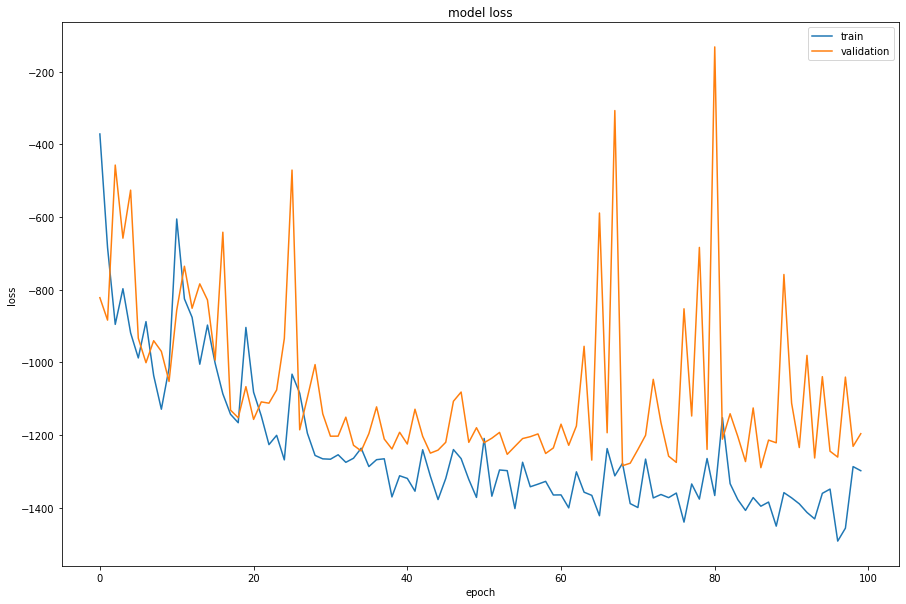

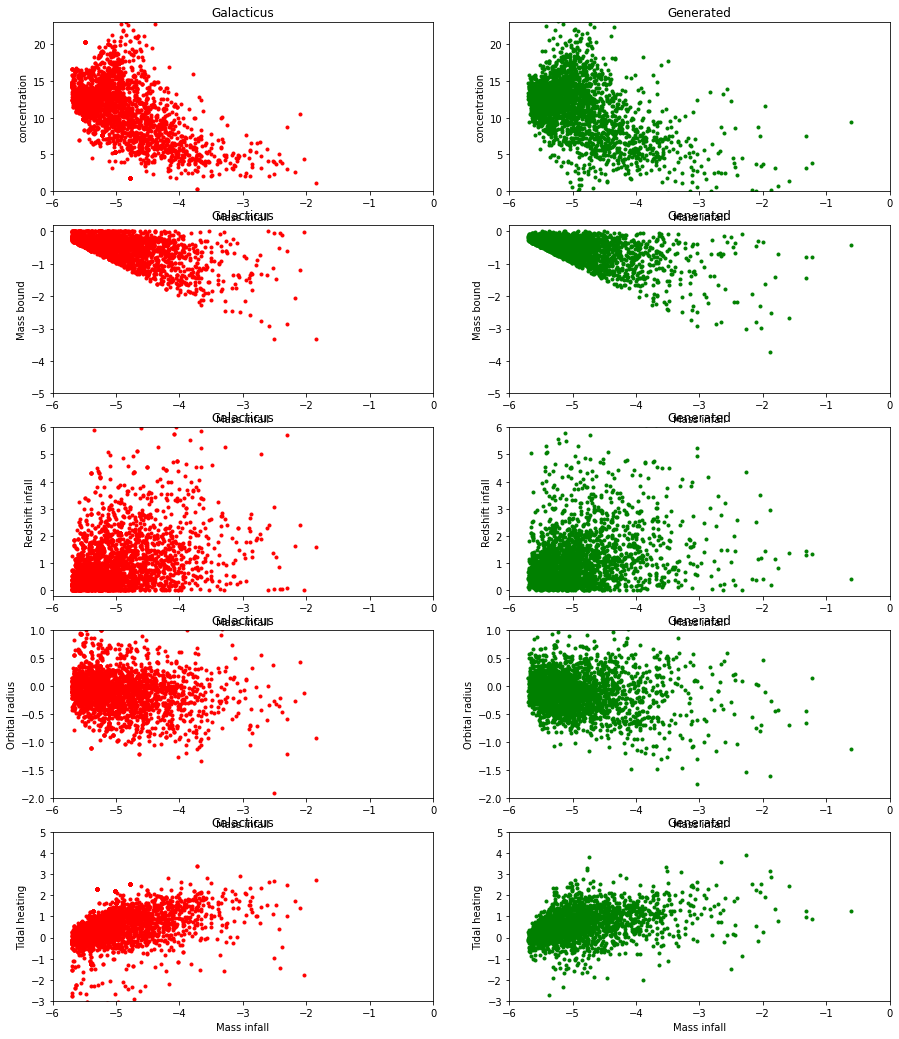

In [6]:
emulator = RealNVP(num_coupling_layers=12)
emulator.load_weights('../data/emulatorModel')

plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = emulator(normalized_data)

# From latent space to data.
samples = emulator.distribution.sample(3000)
x, _ = emulator.predict(samples)
xt = scaler.inverse_transform(x)
clip = (xt[:,0] > np.log10(2.0*massResolution/massTree)) & (xt[:,2] <= 0.0) & (xt[:,2] > -xt[:,0]+np.log10(massResolution/massTree)) & (xt[:,3] >= 0.0)

f, axes = plt.subplots(5, 2)
f.set_size_inches(15, 18)

# Generate a weighted subsample of the original data.
w = weight[subhalos]
i = np.arange(0, w.size, 1, dtype=int)
subsample = np.random.choice(i, size=3000, replace=True, p=w/np.sum(w))

# Compute and compare the ratio of low-to-high-mass subhalos in the original data and in the emulated data.
# For the original data we weight by the subsampling weight. If this was included correctly in the training
# then the emulated data should have effectively learned these weights and produce a ratio similar to that in
# the original data.
s6 = data[:,0] > -6.0
s4 = data[:,0] > -4.0
ratioOriginal = np.sum(data[s6,0]*w[s6])/np.sum(data[s4,0]*w[s4])
print("Ratio of low-to-high-mass subhalos in original data (weighted): "+str(ratioOriginal))

ratioEmulator = np.sum(xt[clip,0] > -6.0)/np.sum(xt[clip,0] > -4.0)
print("Ratio of low-to-high-mass subhalos in emulated data: "+str(ratioEmulator))

axes[0, 0].scatter(data[subsample, 0], data[subsample, 1], color="r", s=9)
axes[0, 0].set(title="Galacticus", xlabel="Mass infall", ylabel="concentration")
axes[0, 0].set_xlim([-6, 0])
axes[0, 0].set_ylim([0, 23])
axes[0, 1].scatter(xt[clip, 0], xt[clip, 1], color="g", s=9)
axes[0, 1].set(title="Generated", xlabel="Mass infall", ylabel="concentration")
axes[0, 1].set_xlim([-6, 0])
axes[0, 1].set_ylim([0, 23])
axes[1, 0].scatter(data[subsample, 0], data[subsample, 2], color="r", s=9)
axes[1, 0].set(title="Galacticus", xlabel="Mass infall", ylabel="Mass bound")
axes[1, 0].set_xlim([-6, 0])
axes[1, 0].set_ylim([-5.0, 0.2])
axes[1, 1].scatter(xt[clip, 0], xt[clip, 2], color="g", s=9)
axes[1, 1].set(title="Generated", xlabel="Mass infall", ylabel="Mass bound")
axes[1, 1].set_xlim([-6, 0])
axes[1, 1].set_ylim([-5.0, 0.2])
axes[2, 0].scatter(data[subsample, 0], data[subsample, 3], color="r", s=9)
axes[2, 0].set(title="Galacticus", xlabel="Mass infall", ylabel="Redshift infall")
axes[2, 0].set_xlim([-6, 0])
axes[2, 0].set_ylim([-0.2, 6.0])
axes[2, 1].scatter(xt[clip, 0], xt[clip, 3], color="g", s=9)
axes[2, 1].set(title="Generated", xlabel="Mass infall", ylabel="Redshift infall")
axes[2, 1].set_xlim([-6, 0])
axes[2, 1].set_ylim([-0.2, 6.0])
axes[3, 0].scatter(data[subsample, 0], data[subsample, 4], color="r", s=9)
axes[3, 0].set(title="Galacticus", xlabel="Mass infall", ylabel="Orbital radius")
axes[3, 0].set_xlim([-6, 0])
axes[3, 0].set_ylim([-2.0, 1.0])
axes[3, 1].scatter(xt[clip, 0], xt[clip, 4], color="g", s=9)
axes[3, 1].set(title="Generated", xlabel="Mass infall", ylabel="Orbital radius")
axes[3, 1].set_xlim([-6, 0])
axes[3, 1].set_ylim([-2.0, 1.0])
axes[4, 0].scatter(data[subsample, 0], data[subsample, 5], color="r", s=9)
axes[4, 0].set(title="Galacticus", xlabel="Mass infall", ylabel="Tidal heating")
axes[4, 0].set_xlim([-6, 0])
axes[4, 0].set_ylim([-3.0, 5.0])
axes[4, 1].scatter(xt[clip, 0], xt[clip, 5], color="g", s=9)
axes[4, 1].set(title="Generated", xlabel="Mass infall", ylabel="Tidal heating")
axes[4, 1].set_xlim([-6, 0])
axes[4, 1].set_ylim([-3.0, 5.0])

Create a function that generates a realization of a subhalo population. The number of subhalos is drawn from a Poisson distribution with the expected mean. A subhalo population is then generated from the emulator, and clipped.

In [63]:
def generateRealization(countSubhalosMean,emulator):
    countSubhalosRealization = np.random.poisson(countSubhalosMean,1)[0]
    samples = emulator.distribution.sample(2*countSubhalosRealization)
    x, _ = emulator.predict(samples)
    xt = scaler.inverse_transform(x)
    clip = np.nonzero((xt[:,0] > np.log10(2.0*massResolution/massTree)) & (xt[:,2] <= 0.0) & (xt[:,2] > -xt[:,0]+np.log10(massResolution/massTree)) & (xt[:,3] >= 0.0))
    clipLimited = clip[0][0:countSubhalosRealization-1]
    return xt[clipLimited,:]

Generate realizations.

In [64]:
realization=generateRealization(countSubhalosMean,emulator)
print("Number of subhalos in realization = "+str(realization.shape[0]))

Number of subhalos in realization = 9738
